# OptML Project : Background Work Notebook

This notebook contains work performed for the project, but that has not been kept into the final report for several reasons.

 The work here is mainly unorganized, and some parts unfortunately cannot be ran in the actual state of the repository. This is more here to display unfinished/unpolished ideas and for us to come back to if needed as well.

 ### Re-definition of the core functions

In [14]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal
import scipy
from skimage.metrics import structural_similarity as compute_ssim
import pandas as pd
import random 
import pandas as pd
import pooch
import cv2 
import seaborn as sns

In [3]:
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]

In [4]:
Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]

In [5]:
def prox_f_conj (u, Lambda) :
    """
    The Dual proximal operator of the anisotropic term, as defined in ForwardBackwardDual.ipynb. Returns the operator, 
    applied to the 'u' variable.

    Parameters 
    ----------
    u : The 3D array on which the operator should be applied,
    Lambda : The regularization coefficient for the anisotropic TV term.

    Returns 
    ---------
    The resulting ndarray from the application of the operator.
    
    """
    if Lambda == 0:
        return u 
    else:
        return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/(Lambda),1),(1,1,2)) # soft-thresholding


In [6]:
def proximal_L12_operator(u,gamma,Lambda) : 
    """
    Applies the proximal operator of the L21 norm, using the Dual proximal operator of the latter.

    Parameters 
    ----------
    u : The 3D array on which the operator should be applied,
    Lambda : The regularization coefficient for the anisotropic TV term.

    Returns 
    ---------
    The resulting ndarray from the application of the operator.
    
    """

    return( (u - gamma*prox_f_conj(u/gamma,Lambda)))

In [7]:
def proximal_operator_L1(u, alpha,gamma):
    """  
    Applies the proximal operator of the L1 norm.
    
    Parameters
    ----------
    u : Multidim. array to which we apply the proximal operator. (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)

    Returns 
    ---------
    The resulting ndarray from the application of the L1 norm proximal operator.

    """
    #return np.sign(u) * np.maximum(abs(u) - alpha,0)
    L1 = pyproximal.L1(sigma=alpha)
    try:
        #Apply the TV proximal operator to u, scaled by 1/gamma, then reshape the result to what we need
        prox_result = L1.prox(u,gamma).reshape(u.shape)
        #print(f"TV.prox result shape: {result.shape}")
        return prox_result
    except Exception as e:
        print(f"Error in TV.prox: {e}")
        raise

In [8]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    gamma : The proximal scaling gamma term (float)
    alpha : Constant that multiplies the Anisotropic term, controlling its regularization strength. (float)
    Lambda : Constant that multiplies the Isotropic term, controlling its regularization strength. (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    redef_u = u + gamma * D(x)
    prox_lasso = proximal_operator_L1(redef_u/gamma, alpha, 1/gamma)
    prox_tv = proximal_L12_operator(prox_lasso, 1/gamma, Lambda)
    proximal_composition = gamma * prox_tv
    return redef_u - proximal_composition

In [9]:
def original_chambolle_algorithm(noised_image,Lambda,gamma,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter) 

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = prox_f_conj(u+gamma*D(x),Lambda)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) 
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of
    #  noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


In [10]:
def chambolle_algorithm(noised_image,Lambda,gamma,alpha,nbiter) :
    """
    Perform denoising on a noised image using the Chambolle's algorithm.

    Parameters
    ----------
    noised_image : Input image, corrupted by noise (2-D np.ndarray)
    Lambda : Multiplicative coefficient of the TV term (float)
    gamma : Proximal operators coefficient (float)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    nbiter : Number of iterations to run the algorithm (int)

    Returns
    -------
    xdenoised : The denoised image obtained after `nbiter` iterations. (2-D np.ndarray)
    Ep_array : Array containing the primal energy values at each iteration. (np.ndarray)
    Ed_array : Array containing the dual energy values at each iteration. (np.ndarray)

"""
    #Initializing u & x
    (N1,N2) = noised_image.shape
    u = np.zeros([N1,N2,2])
    x = np.zeros([N1,N2,2])

    #Initializing energy arrays
    Ep_array = np.zeros(nbiter) 
    Ed_array = np.zeros(nbiter) 

    #Squared norm of the noised image
    sqnormy = np.linalg.norm(noised_image)**2/2

    #Iterations of the Chambolle Algorithm
    for iter in range(nbiter):  

        #Computing x and u, appending resulting energies in their respective arrays
        x = -Dadj(u) + noised_image
        u = complete_proximal_operator(u,x,gamma,Lambda,alpha)
        Ep_array[iter] = np.linalg.norm(x-noised_image)**2/2 + Lambda*np.sum(np.sqrt(np.sum(D(x)**2,2))) + alpha * np.sum(np.abs(D(x)))
        Ed_array[iter] = np.linalg.norm(noised_image-Dadj(u))**2/2 - sqnormy
    
    #Last x obtained is the denoised version of noised_image, we return it
    xdenoised = x
    return xdenoised,Ep_array,Ed_array


In [11]:
def calculate_ssim(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    ssim_value = compute_ssim(img1, img2, data_range=max_value)
    return ssim_value

def calculate_psnr(img1, img2, max_value=255):
    img1 = np.asarray(img1, dtype=np.float32)
    img2 = np.asarray(img2, dtype=np.float32)
    
    if img1.shape != img2.shape:
        raise ValueError(f"Input images must have the same dimensions: img1.shape = {img1.shape}, img2.shape = {img2.shape}")
    
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / np.sqrt(mse))

### Trying combinations of $\lambda$ & $\alpha$ on different noise levels

Following up on the heatmaps generated in the main notebook, we try to see how the PSNR and SSIM evolves for different noise levels, in three different cases :

- Approximately equal values of $\lambda$ and $\alpha$ 
- Low $\lambda$, high $\alpha$ 
- High $\lambda$, low $\alpha$

In [13]:
Lambda = 25
gamma = 1.9/8 # we must have 0 < gamma < 2/8
nbiter = 400
alpha = 10

xsharp = scipy.datasets.ascent()
xsharp = xsharp.astype(np.float32) 
(N1,N2) = np.shape(xsharp)
noiselevel = 35
noised_image = xsharp + noiselevel * np.random.randn(N1,N2)

noise_levels = [15, 25, 45, 60]

# Ranges for alpha and lambda
alphas = [1, 10, 20, 30, 40, 50]
lambdas = [1, 10, 20, 30, 40, 50]

# Create an empty dictionary to store DataFrames for each noise level
results = {}

# Iterate over each noise level
for noise_level in noise_levels:
    psnr_results = []
    ssim_results = []
    
    noised_img = xsharp + noise_level * np.random.randn(N1, N2)
    
    # Combinations of equal alpha and lambda
    for alpha, lambda_ in zip(alphas, lambdas):
        denoised_img, _, _ = chambolle_algorithm(noised_img, lambda_, gamma, alpha, nbiter)
        psnr = calculate_psnr(xsharp, denoised_img)
        ssim_value = calculate_ssim(xsharp, denoised_img)
        psnr_results.append(('Equal alpha and lambda', alpha, lambda_, psnr))
        ssim_results.append(('Equal alpha and lambda', alpha, lambda_, ssim_value))
        
    
    # High lambda and low alpha
    for lambda_ in lambdas[-3:]:  # High lambda values
        for alpha in alphas[:3]:  # Low alpha values
            denoised_img, _, _ = chambolle_algorithm(noised_img, lambda_, gamma, alpha, nbiter)
            psnr = calculate_psnr(xsharp, denoised_img)
            ssim_value = calculate_ssim(xsharp, denoised_img)
            psnr_results.append(('High lambda, Low alpha', alpha, lambda_, psnr))
            ssim_results.append(('High lambda, Low alpha', alpha, lambda_, ssim_value))

    # Low lambda and high alpha
    for lambda_ in lambdas[:3]:  # Low lambda values
        for alpha in alphas[-3:]:  # High alpha values
            denoised_img, _, _ = chambolle_algorithm(noised_img, lambda_, gamma, alpha, nbiter)
            psnr = calculate_psnr(xsharp, denoised_img)
            ssim_value = calculate_ssim(xsharp, denoised_img)
            psnr_results.append(('Low lambda, High alpha', alpha, lambda_, psnr))
            ssim_results.append(('Low lambda, High alpha', alpha, lambda_, ssim_value))
    
    # Create DataFrames for PSNR and SSIM results
    psnr_df = pd.DataFrame(psnr_results, columns=['Case', 'Alpha', 'Lambda', 'PSNR'])
    ssim_df = pd.DataFrame(ssim_results, columns=['Case', 'Alpha', 'Lambda', 'SSIM'])
    
    # Store the DataFrames in the results dictionary
    results[noise_level] = {'PSNR': psnr_df, 'SSIM': ssim_df}

    print('finished a full iteration for a noise level')

finished a full iteration for a noise level
finished a full iteration for a noise level
finished a full iteration for a noise level
finished a full iteration for a noise level


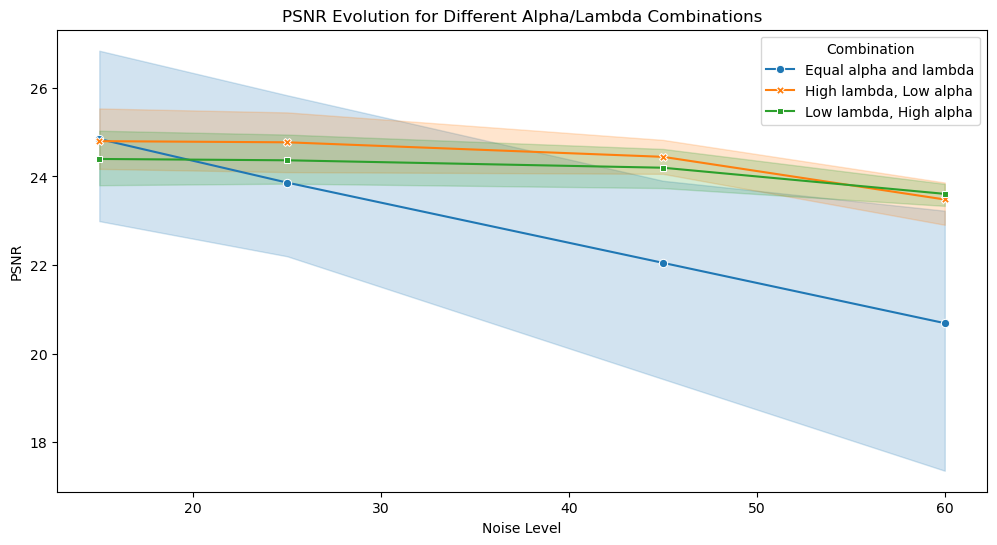

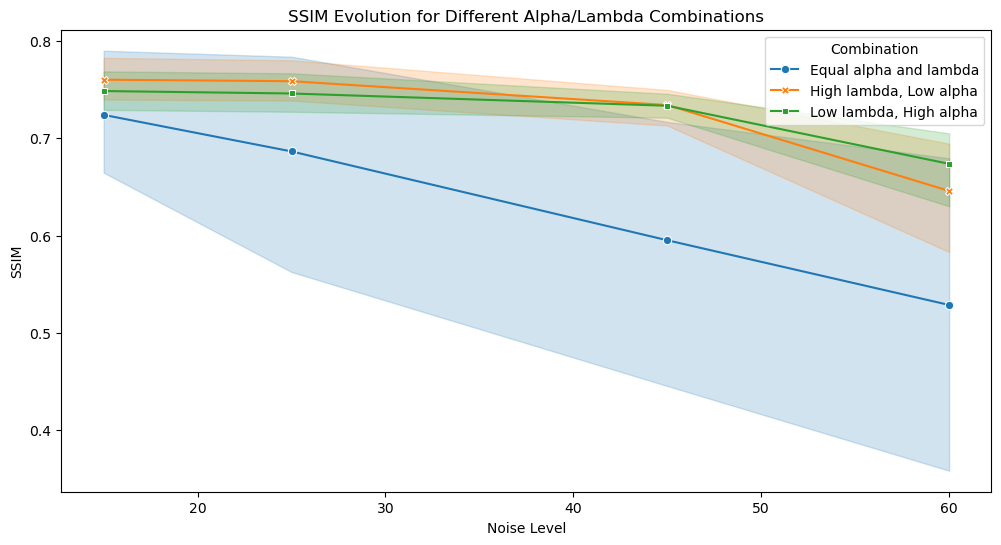

In [21]:
psnr_aggregated = []
ssim_aggregated = []

# Aggregate results across noise levels
for noise_level, metrics in results.items():
    for _, row in metrics['PSNR'].iterrows():
        psnr_aggregated.append((row['Case'], row['Alpha'], row['Lambda'], noise_level, row['PSNR']))
    for _, row in metrics['SSIM'].iterrows():
        ssim_aggregated.append((row['Case'], row['Alpha'], row['Lambda'], noise_level, row['SSIM']))

# Convert aggregated results to DataFrames
psnr_df = pd.DataFrame(psnr_aggregated, columns=['Case', 'Alpha', 'Lambda', 'Noise Level', 'PSNR'])
ssim_df = pd.DataFrame(ssim_aggregated, columns=['Case', 'Alpha', 'Lambda', 'Noise Level', 'SSIM'])

# Function to create line plots for PSNR and SSIM
def plot_metric(df, metric):
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Noise Level', y=metric, hue='Case', style='Case', markers=True, dashes=False)
    plt.title(f'{metric} Evolution for Different Alpha/Lambda Combinations')
    plt.ylabel(metric)
    plt.xlabel('Noise Level')
    plt.legend(title='Combination')
    plt.show()

# Plot PSNR
plot_metric(psnr_df, 'PSNR')

# Plot SSIM
plot_metric(ssim_df, 'SSIM')

### Results with other types of noise

In [16]:
def add_sap_noise(img,noise_level): 
  
    noisy_img = np.copy(img) 
    row , col = noisy_img.shape 
      
    number_of_pixels = noise_level
    #Randomly select a pixel, color it to white
    for i in range(number_of_pixels): 
        
        y_coord=random.randint(0, row - 1) 
        x_coord=random.randint(0, col - 1)  
        noisy_img[y_coord][x_coord] = 255
          
    number_of_pixels = noise_level
    #Randomly select a pixel, color it to black
    for i in range(number_of_pixels): 
        
        y_coord=random.randint(0, row - 1) 
        x_coord=random.randint(0, col - 1) 
        noisy_img[y_coord][x_coord] = 0
          
    return noisy_img 

In [ ]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
import pyproximal
import scipy
from skimage.metrics import structural_similarity as compute_ssim
import pandas as pd
import random 
import pandas as pd
import pooch
import cv2 

In [17]:
def add_poisson_noise(image):
    """
    Add Poisson noise to the input image.
    
    Parameters:
    - image: Input image (grayscale), numpy array of shape (height, width).
    
    Returns:
    - noisy_image: Image with added Poisson noise, numpy array of same shape and dtype as input.
    """

    if image.dtype != np.float64:
        image = image.astype(np.float64)
    noisy_image = np.random.poisson(image)
    
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)
    
    return noisy_image

In [18]:
def add_periodic_noise(image, frequency=10):
    if len(image.shape) != 2:
        raise ValueError("Input image must be 2D (grayscale)")
    
    h, w = image.shape
    x = np.arange(w)
    y = np.arange(h)
    X, Y = np.meshgrid(x, y)
    noise = np.sin(2 * np.pi * frequency * Y / h) * 128 + 128
    
    # Ensure noise shape matches image shape
    if noise.shape != image.shape:
        raise ValueError("Noise shape does not match image shape")
    
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)
    return noisy_image

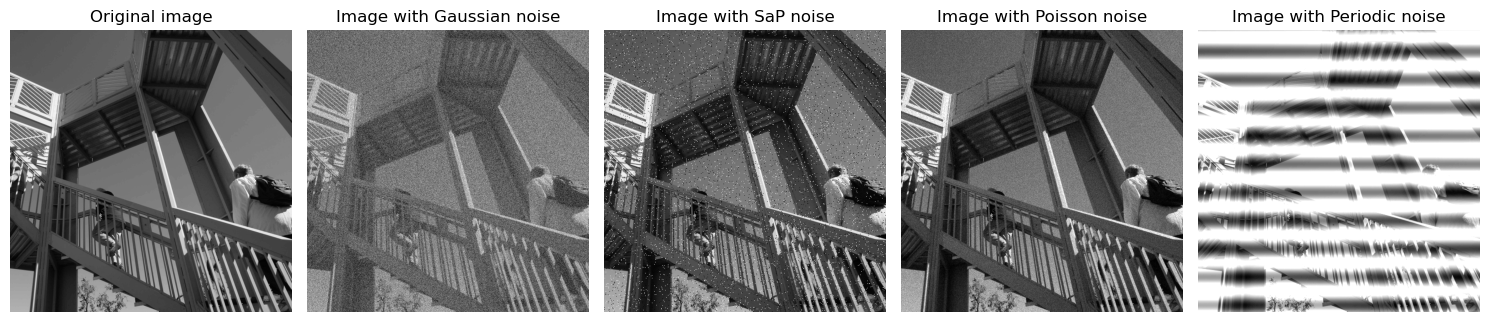

In [19]:
fig, axs = plt.subplots(1, 5, figsize=(15, 5))

axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Original image')

axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with Gaussian noise')

axs[2].imshow(add_sap_noise(xsharp,5000), cmap='gray')
axs[2].set_title('Image with SaP noise')

axs[3].imshow(add_poisson_noise(xsharp), cmap='gray')
axs[3].set_title('Image with Poisson noise')


axs[4].imshow(add_periodic_noise(xsharp), cmap='gray')
axs[4].set_title('Image with Periodic noise')


for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()

### Trying to generate images with special pattern shapes to study the effect of our implementations

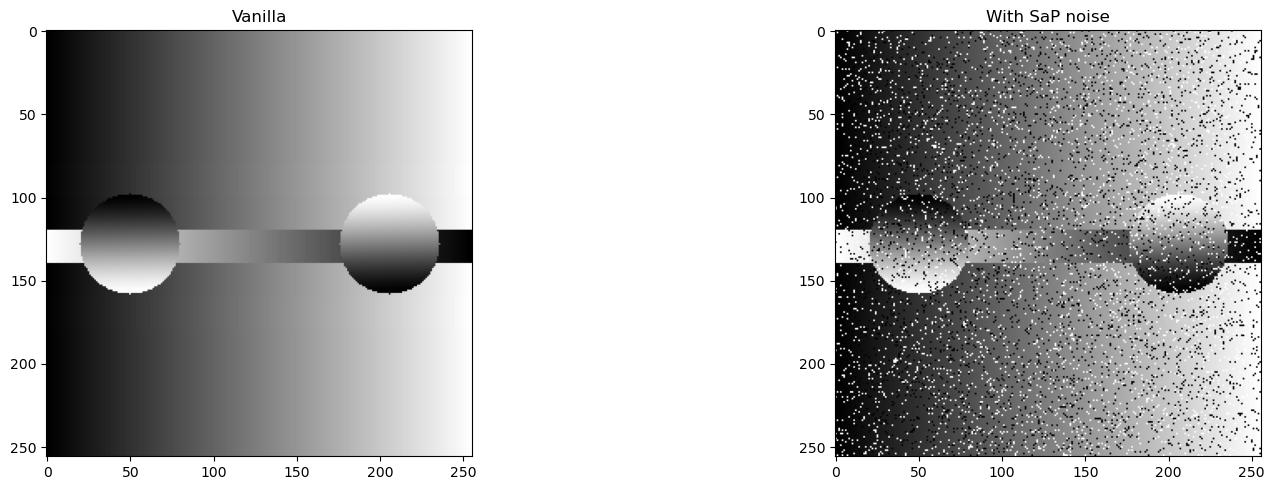

In [22]:
def create_test_pattern():
    img = np.zeros((256, 256))

    # Add vertical gradient
    for i in range(img.shape[1]):
        img[:, i] = i / img.shape[1]

    # Add horizontal stripes
    img[80:100, :] = np.linspace(0, 1, img.shape[1])
    img[120:140, :] = np.linspace(1, 0, img.shape[1])
    img[160:180, :] = np.linspace(0, 1, img.shape[1])

    # Add circles
    y, x = np.ogrid[:256, :256]
    mask1 = (x - 50)**2 + (y - 128)**2 <= 30**2
    mask2 = (x - 206)**2 + (y - 128)**2 <= 30**2
    img[mask1] = np.linspace(0, 1, np.count_nonzero(mask1))
    img[mask2] = np.linspace(1, 0, np.count_nonzero(mask2))

    img = (img * 255).astype(np.uint8)

    return img

pattern = create_test_pattern()
x_noise = add_sap_noise(pattern,4000)

fig, axs = plt.subplots(1, 2, figsize=(18, 5))

axs[0].imshow(pattern, cmap='gray')
axs[0].set_title(f"Vanilla")

axs[1].imshow(x_noise,cmap='gray')
axs[1].set_title(f"With SaP noise")
plt.tight_layout()
plt.show()

In [ ]:
high_both_denoised,_,_ = chambolle_algorithm(x_noise,30,gamma,30,nbiter)
high_onlylambda_denoised,_,_ = chambolle_algorithm(x_noise,60,gamma,0,nbiter)
high_onlyalpha_denoised,_,_ = chambolle_algorithm(x_noise,0.000000000000001,gamma,60,nbiter)

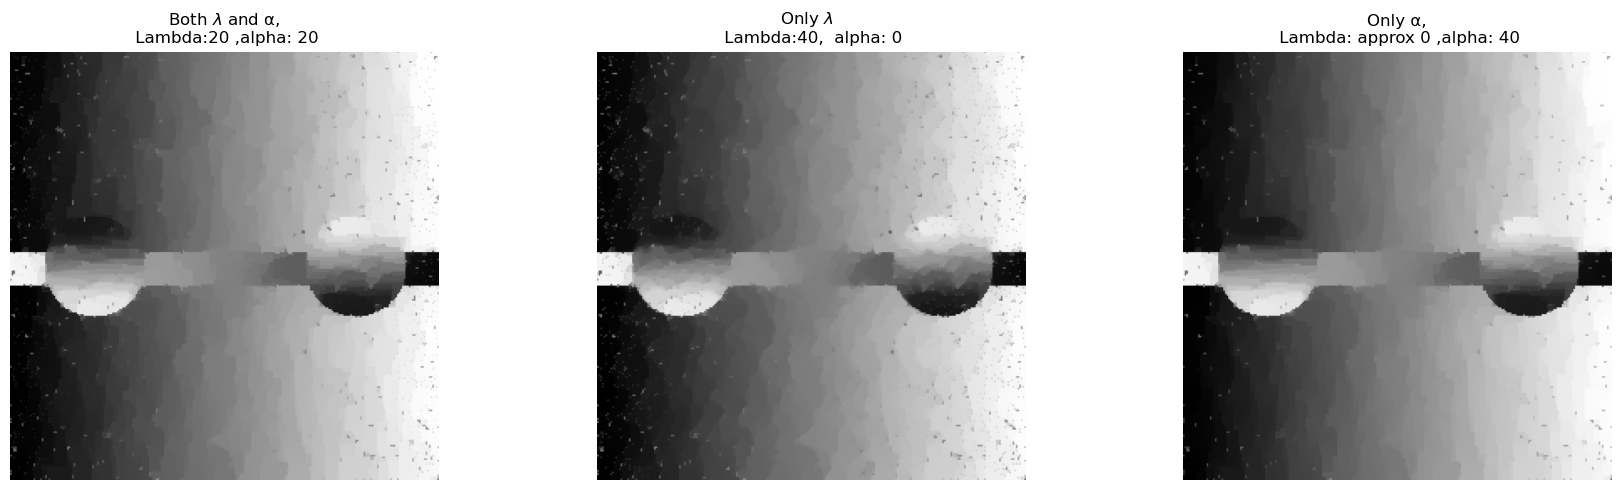

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].imshow(high_both_denoised, cmap='gray')
axs[0].set_title(f"Both $\lambda$ and \u03B1,\n Lambda:{20} ,alpha: {20}")

axs[1].imshow(high_onlylambda_denoised, cmap='gray')
axs[1].set_title(f"Only $\lambda$  \n Lambda:{40},  alpha: {0}")

axs[2].imshow(high_onlyalpha_denoised, cmap='gray')
axs[2].set_title(f"Only \u03B1,\n Lambda: approx {0} ,alpha: {40}")

for ax in axs:
    ax.axis('off')

plt.tight_layout()
plt.show()

Different in 'texture' : less smoothed when considering only the isotropic term or addition of both TVs 

### CBSD68 Color Dataset 

Testing out the results on the benchmark CBSD68 Color dataset, containing 68 colored original images and corrupted versions with gaussian noise levels $\in [5,10,15,25,35,50]$ for each of the originals.

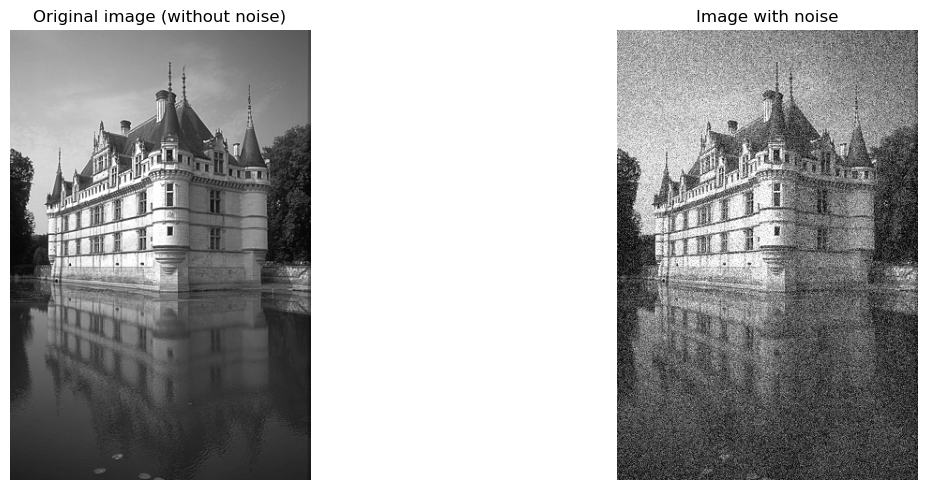

In [ ]:
import matplotlib.image as mpimg

CBSD68_PATH = '../CBSD68/'


from skimage import color
from skimage import io

img = color.rgb2gray(io.imread(CBSD68_PATH +'original_png/0010.png'))
noisy15_img = color.rgb2gray(io.imread(CBSD68_PATH +'noisy35/0010.png'))


# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))


axs[0].imshow(img,cmap='gray')
axs[0].set_title('Original image (without noise)')

# Display each image in a subplot
axs[1].imshow(noisy15_img,cmap='gray')
axs[1].set_title('Image with noise')

# Remove axes for a cleaner look

for ax in axs:
    ax.axis('off')
# Show the plot
plt.tight_layout()
plt.show()

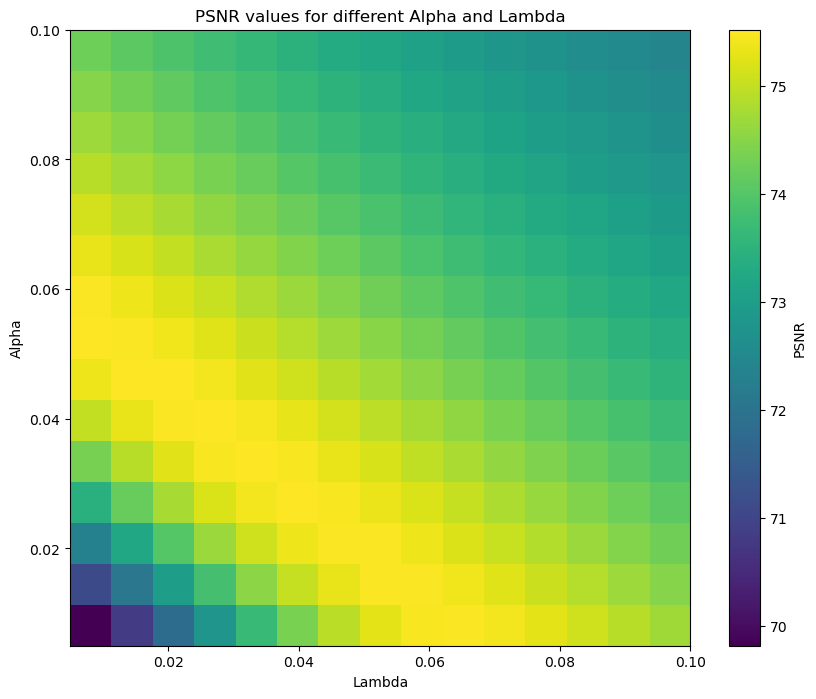

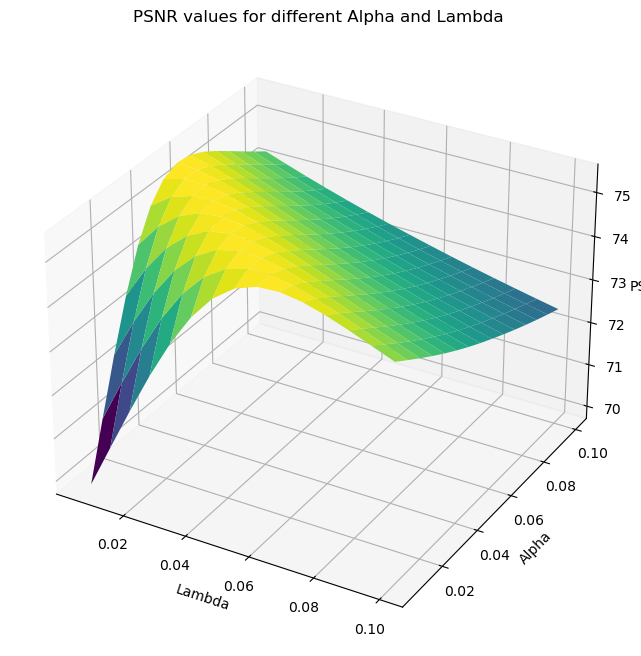

In [ ]:
alphas = np.linspace(0.005, 0.1, 15) 
lambdas = np.linspace(0.005, 0.1, 15)  

psnr_values = np.zeros((len(alphas), len(lambdas)))

for i, alpha in enumerate(alphas):
    for j, Lambda in enumerate(lambdas):
        denoised_image_,_,_ = chambolle_algorithm(noisy15_img, Lambda, gamma, alpha, nbiter=200)
        psnr = calculate_psnr(img, denoised_image_)
        psnr_values[i, j] = psnr

plt.figure(figsize=(10, 8))
plt.imshow(psnr_values, cmap='viridis', aspect='auto', extent=[lambdas[0], lambdas[-1], alphas[0], alphas[-1]], origin='lower')
plt.colorbar(label='PSNR')
plt.xlabel('Lambda')
plt.ylabel('Alpha')
plt.title('PSNR values for different Alpha and Lambda')
plt.show()

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
L, A = np.meshgrid(lambdas, alphas)
ax.plot_surface(L, A, psnr_values, cmap='viridis')
ax.set_xlabel('Lambda')
ax.set_ylabel('Alpha')
ax.set_zlabel('PSNR')
ax.set_title('PSNR values for different Alpha and Lambda')
plt.show()

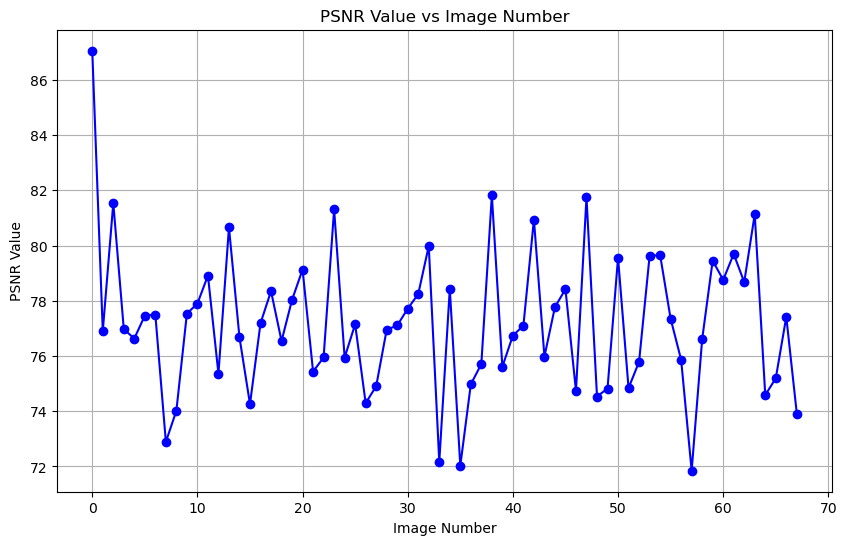

In [ ]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image,_,_ = chambolle_algorithm(noisy_img, 0.02, gamma, 0.03, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

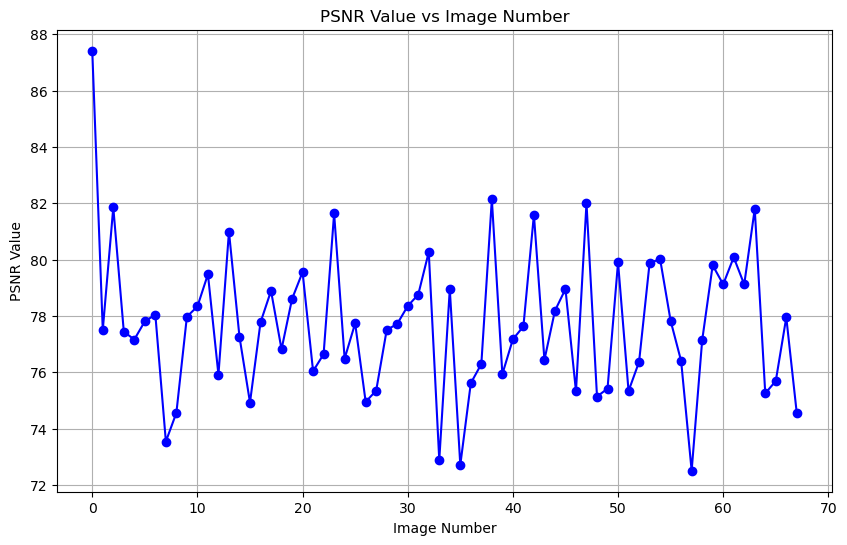

In [ ]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image, _, _ = chambolle_algorithm(noisy_img, 0.05, gamma, 0, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: divide by zero encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding
C:\Users\dryha\AppData\Local\Temp\ipykernel_26920\1176656996.py:2: RuntimeWarning: invalid value encountered in divide
  return u/np.tile(np.maximum(np.sqrt(np.sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding


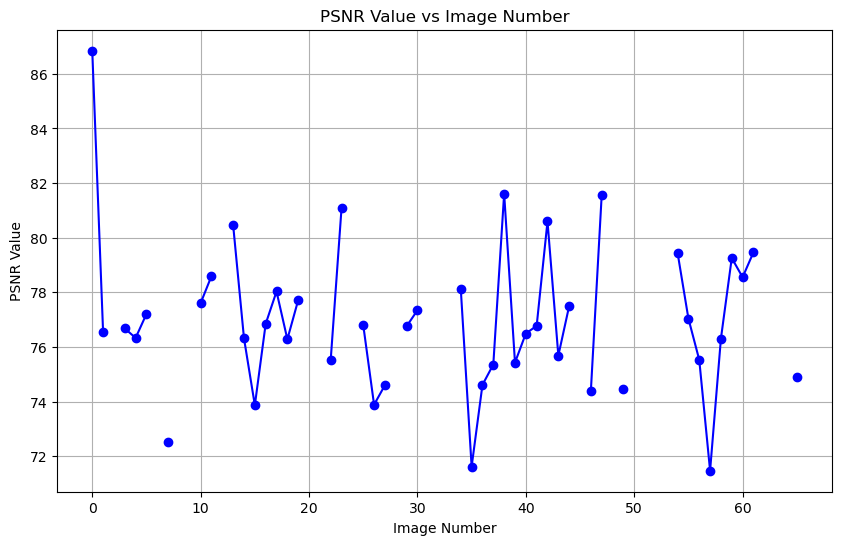

In [ ]:
import os
from os import listdir
from os.path import isfile, join


onlyfiles = [f for f in listdir(CBSD68_PATH+'/noisy15') if isfile(join(CBSD68_PATH+'/noisy15', f))]

psnr_values = []
image_indices = []

for idx, IMG_NAME in enumerate(onlyfiles):

    img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/original_png/', IMG_NAME)))
    noisy_img = color.rgb2gray(io.imread(os.path.join(CBSD68_PATH+'/noisy15/', IMG_NAME)))
    
    denoised_image, _, _ = chambolle_algorithm(noisy_img, 0, gamma, 0.05, nbiter=200)
    
    psnr_value = calculate_psnr(img, denoised_image)

    psnr_values.append(psnr_value)
    image_indices.append(idx)  
    

plt.figure(figsize=(10, 6))
plt.plot(image_indices, psnr_values, marker='o', linestyle='-', color='b')
plt.title('PSNR Value vs Image Number')
plt.xlabel('Image Number')
plt.ylabel('PSNR Value')
plt.grid(True)
plt.show()

#### Additional : Trying to revert the composition of proximal operators

Here we implement the exact same algorithm as before, with the sole exception of modifying the composition of proximal operators in the Chambolle algorithm iterations. This means that, with


$$ f(x) = \lambda\|x\|_{1,2} $$
$$ g(x) =  \alpha \lVert x \rVert_{1} $$ 

We obtain :

$$\big(\text{prox}_{\gamma h^*}(u)\big) = u - \gamma \text{prox}_{h/\gamma}(u/\gamma) = u - \gamma \text{prox}_{f / \gamma}(\text{prox}_{g / \gamma}(u/\gamma) ).$$

To decipher this composition of proximal iterators, we need $\text{prox}_{\gamma f^*}(u)$ to appear, as it is the one we have. Using the Moreau decomposition once more, we can write


$$ \gamma \text{prox}_{f/\gamma}(u/\gamma) = u - \text{prox}_{f^*}(u)
$$ 

By then setting $v = \frac{u}{\gamma}$, we obtain

$$ \gamma \text{prox}_{f/\gamma}(v) = \gamma v - \text{prox}_{f^*}(\gamma v)
$$ 

We thus obtain, by replacing $v$ with $\text{prox}_{g / \gamma}(u/\gamma)$


$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u - ( \gamma\text{prox}_{g / \gamma}(u/\gamma) - \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma))) $$

$$ \big(\text{prox}_{\gamma h^*}(u)\big) = u -  \gamma\text{prox}_{g / \gamma}(u/\gamma) + \text{prox}_{\gamma f^* }(\gamma\text{prox}_{g / \gamma}(u/\gamma)) $$



In [ ]:
def complete_proximal_operator(u, x, gamma, Lambda, alpha):
    """  
    Computes the final composition of proximal operators.
    
    Parameters
    ----------
    u : The u value of the current iteration (np.ndarray)
    x : The x value of the current iteration (np.ndarray)
    alpha : Constant that multiplies the L1 term, controlling regularization strength. (float)
    gamma : The usual gamma term (float)
    Lambda : Multiplicative coefficient of the TV term (float)

    Returns 
    ---------
    u^{k+1}, as described in Chambolle's algorithm.

    """
    #Computing the term at which we evaluate prox_h()
    redef_u = u + gamma * D(x)

    try:

        prox_lasso = proximal_operator_lasso(redef_u/gamma, alpha,gamma)

        proximal_composition = prox_f_conj(gamma*prox_lasso,Lambda)

        return redef_u - gamma*prox_lasso + proximal_composition
    
    except Exception as e:
        print(f"Error in complete_proximal_operator: {e}")
        raise